In [11]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#### Performance evaluation of the Rancher (Kubernetes) HPC cluster with parallel simulation workloads.

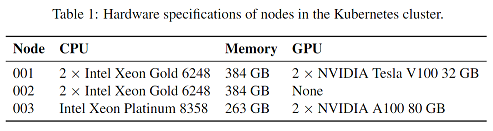

- The study starts with 16 simulation instances running in parallel and 1 instance is dropped every 5 minutes, till a single instance remains.
- The study was conducted on Node 003 (refer Table 1), which was time-sliced into 8 segments per card resulting in a total of 16 GPU replicas.

In [12]:
# Define data directory
data_dir = 'data/hpc_stress_test_1_node_data'

In [13]:
# Define headers in the CSV files
headers = ['Node Name','CPU Cores','CPU Usage (%)','Memory Usage (MiB)','Memory Usage (%)','GPU Index','GPU Name','GPU Usage (%)','GPU Memory Usage (%)','GPU Memory Total (MiB)','GPU Memory Usage (MiB)','GPU Power Usage (W)']

# Read each CSV file in data directory
logs = []
for file in sorted(Path(data_dir).glob("hpc_metrics_*.csv")):
    logs.append(pd.read_csv(file, skiprows=1, names=headers))

# View the first 5 entries in the first dataframe
logs[0].head()

Node Name  CPU Cores  CPU Usage (%)  Memory Usage (MiB)  \
0  tw0004.dev.rcd.clemson.edu      39139             61               88129   
1  tw0004.dev.rcd.clemson.edu      39450             61               88631   
2  tw0004.dev.rcd.clemson.edu      39450             61               88631   
3  tw0004.dev.rcd.clemson.edu      40559             63               92542   
4  tw0004.dev.rcd.clemson.edu      40559             63               92542   

   Memory Usage (%)  GPU Index               GPU Name  GPU Usage (%)  \
0                34          0  NVIDIA A100 80GB PCIe            100   
1                34          0  NVIDIA A100 80GB PCIe            100   
2                34          0  NVIDIA A100 80GB PCIe            100   
3                35          0  NVIDIA A100 80GB PCIe            100   
4                35          0  NVIDIA A100 80GB PCIe            100   

   GPU Memory Usage (%)  GPU Memory Total (MiB)  GPU Memory Usage (MiB)  \
0                     2                   81920                   17889   
1                     2                   81920                   17876   
2                     2                   81920                   17880   
3                     2                   81920                   18151   
4                     2                   81920                   18201   

   GPU Power Usage (W)  
0               141.09  
1               153.88  
2               157.16  
3               135.60  
4               144.53

In [14]:
# Extract separation bounds of different dataframes
bounds = [0]
for log in logs:
    bounds.append(bounds[-1] + max(log.index))
bounds = bounds[1:]
bounds

[53, 107, 165, 223, 279, 336, 391, 449, 506, 563, 622, 679, 736, 794, 853, 911]

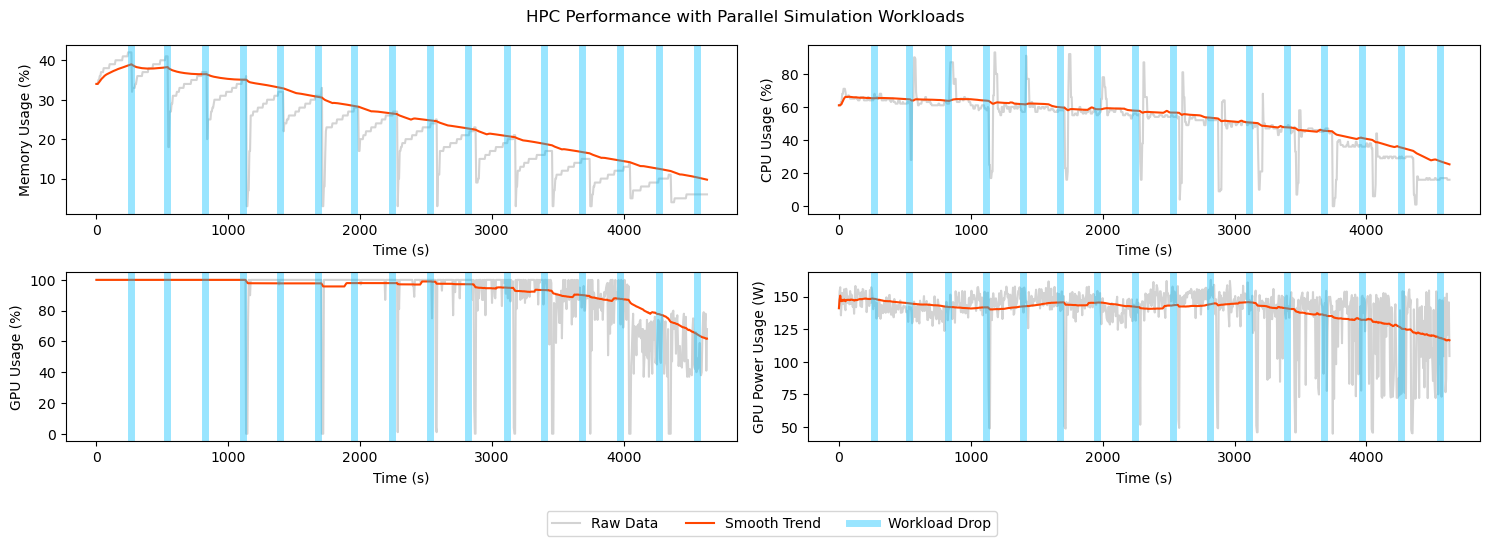

In [15]:
# Visualize the data

# Set figure size and sub-plot grid
fig = plt.figure(figsize=(15, 5))
fig.suptitle("HPC Performance with Parallel Simulation Workloads")
G = gridspec.GridSpec(2, 2)

# Concatenate all dataframes into a single one
concatenated_log = pd.concat([df.reset_index(drop=True).reset_index(drop=False) for df in logs], ignore_index=True)

# Plot Y-position vs. X-position
axes_1 = plt.subplot(G[0, 0])
axes_1.plot(5*concatenated_log.index, concatenated_log['Memory Usage (%)'], color='lightgray')
axes_1.plot(5*concatenated_log.index, concatenated_log['Memory Usage (%)'].rolling(window=250, min_periods=1).mean(), color='orangered')
for bound in bounds:
    axes_1.axvline(x=5*bound, color='deepskyblue', alpha=0.4, linewidth=5.0)
axes_1.set_xlabel(r"Time (s)")
axes_1.set_ylabel(r"Memory Usage (%)")

# Plot AEB Trigger vs. Timestamp
axes_2 = plt.subplot(G[0, 1])
axes_2.plot(5*concatenated_log.index, concatenated_log['CPU Usage (%)'], color='lightgray')
axes_2.plot(5*concatenated_log.index, concatenated_log['CPU Usage (%)'].rolling(window=150, min_periods=1).mean(), color='orangered')
for bound in bounds:
    axes_2.axvline(x=5*bound, color='deepskyblue', alpha=0.4, linewidth=5.0)
axes_2.set_xlabel(r"Time (s)")
axes_2.set_ylabel(r"CPU Usage (%)")

# Plot DTC vs. Timestamp
axes_3 = plt.subplot(G[1, 0])
axes_3.plot(5*concatenated_log.index, concatenated_log['GPU Usage (%)'], color='lightgray')
axes_3.plot(5*concatenated_log.index, concatenated_log['GPU Usage (%)'].rolling(window=150, min_periods=1).mean(), color='orangered')
for bound in bounds:
    axes_3.axvline(x=5*bound, color='deepskyblue', alpha=0.4, linewidth=5.0)
axes_3.set_xlabel(r"Time (s)")
axes_3.set_ylabel(r"GPU Usage (%)")

# Plot Collision Count vs. Timestamp
axes_4 = plt.subplot(G[1, 1])
axes_4.plot(5*concatenated_log.index, concatenated_log['GPU Power Usage (W)'], color='lightgray')
axes_4.plot(5*concatenated_log.index, concatenated_log['GPU Power Usage (W)'].rolling(window=150, min_periods=1).mean(), color='orangered')
for bound in bounds:
    axes_4.axvline(x=5*bound, color='deepskyblue', alpha=0.4, linewidth=5.0)
axes_4.set_xlabel(r"Time (s)")
axes_4.set_ylabel(r"GPU Power Usage (W)")

# Show the plot
plt.tight_layout()
plt.legend(['Raw Data', 'Smooth Trend', 'Workload Drop'], loc='lower left', bbox_to_anchor=(-0.4, -0.6), ncols=3)
plt.show()